# SWSSL Anomaly Detection Pipeline

This notebook implements the complete pipeline for **Sliding Window-based Self-Supervised Learning (SWSSL)** for anomaly detection in Chest X-Ray images.

## Pipeline Steps:
1. Import libraries and set up environment
2. Configure hyperparameters
3. Load datasets
4. Initialize model
5. Define loss function
6. Train the model
7. Evaluate and save results

## 1. Import Libraries

In [3]:
pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/6f/d3/a4bbc01c237ab710a1f22b4da72f4ff6d77eb4c7735ea9811a94ae239067/matplotlib-3.10.8-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl.metadata (52 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/98/4b/9bd370b004b5c9d8045c6c33cf65bae018b27aca550a3f657cdc99acdbd8/contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/07/ad/37dd1ae5fa6e01612a1fbb954f0927681f28292


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import random
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import local modules
from utils import *
from evaluate import evaluate_image
from dataset import ChestDataset
from models import Patch_Model

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch Version: 2.9.1+cpu
Device: cpu


## 2. Configuration

In [2]:
class Args:
    def __init__(self):
        self.phase = 'train'
        # Update this path to your actual dataset location
        self.dataset_path = r"C:\Users\sharm\OneDrive\Documents\Desktop\minor project\swssl-for-anomaly-detection\ChestXRay2017\chest_xray"
        self.category = 'chest'
        self.batch_size = 32  # Reduced for CPU/Memory safety
        self.load_size = 256
        self.input_size = 256
        self.coreset_sampling_ratio = 0.01
        self.project_root_path = 'results'
        self.save_src_code = True
        self.save_anomaly_map = True
        self.n_neighbors = 9
        self.lr = 1e-4
        self.k = 9
        self.learning_rate_weights = 0.01
        self.learning_rate_biases = 0.0048
        self.weight_decay = 1e-6
        self.epochs = 10  # Reduced for testing
        self.patch_size = 128
        self.step_size = 32
        self.use_tumor = 0

args = Args()
print(f"Configuration loaded.")
print(f"Dataset path: {args.dataset_path}")
print(f"Epochs: {args.epochs}, Batch size: {args.batch_size}, Patch size: {args.patch_size}")

Configuration loaded.
Dataset path: C:\Users\sharm\OneDrive\Documents\Desktop\minor project\swssl-for-anomaly-detection\ChestXRay2017\chest_xray
Epochs: 10, Batch size: 32, Patch size: 128


## 3. Load Datasets

In [3]:
if args.category == 'chest':
    train_transforms = transforms.Compose([
                transforms.Resize((256*4, 256*4), Image.LANCZOS),
    ])

    test_transforms = transforms.Compose([
                transforms.Resize((256*4, 256*4), Image.LANCZOS),
                transforms.ToTensor()
    ])
    
    # Train set (Patch-based for training)
    train_patch_d = ChestDataset(root = args.dataset_path, 
                                        pre_transform = train_transforms,
                                        phase = 'train',
                                        patch = True,
                                        patch_size = args.patch_size, 
                                        step_size = args.step_size)
    
    # Train set (Full image for evaluation/memory bank)
    train_full_d = ChestDataset(root = args.dataset_path, 
                                pre_transform = test_transforms,
                                phase = 'train', 
                                patch = False, 
                                patch_size = args.patch_size, 
                                step_size = args.step_size)
    
    # Test set
    test_full_d = ChestDataset(root = args.dataset_path, 
                                pre_transform = test_transforms,
                                phase = 'test',
                                patch = False,
                                patch_size = args.patch_size, 
                                step_size = args.step_size)

train_patch_loader = DataLoader(train_patch_d, batch_size=args.batch_size, shuffle=True)

# Create subsets for faster periodic evaluation on CPU
# 1. Training subset (Memory Bank) - 10%
indices_train = torch.randperm(len(train_full_d))[:int(len(train_full_d)*0.1)]
train_eval_d = torch.utils.data.Subset(train_full_d, indices_train)
train_eval_loader = DataLoader(train_eval_d, batch_size=args.batch_size, shuffle=False, drop_last=False)

# 2. Testing subset (Validation) - 10% (approx 60 images)
indices_test = torch.randperm(len(test_full_d))[:int(len(test_full_d)*0.1)]
test_eval_d = torch.utils.data.Subset(test_full_d, indices_test)
test_loader = DataLoader(test_eval_d, batch_size=1, shuffle=False)

print(f"Train Patch Dataset: {len(train_patch_d)} images")
print(f"Train Eval Subset: {len(train_eval_d)} images")
print(f"Test Eval Subset: {len(test_eval_d)} images")

train dataset size 1349
train dataset size 1349
test dataset size 624
Train Patch Dataset: 1349 images
Train Eval Subset: 134 images
Test Eval Subset: 62 images


## 4. Initialize Model

In [4]:
model = Patch_Model(input_channel=3)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-5)
print("Model initialized successfully.")

c:\Users\sharm\OneDrive\Documents\Desktop\minor project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sharm\OneDrive\Documents\Desktop\minor project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized successfully.


## 5. Define Loss Function

In [5]:
def twin_loss(f_patch1, f_patch2, f_neg=None, p=False, target=None, f_full1=None, f_full2=None, f_neg_full=None):
    batch_size, dimension = f_patch1.shape
    device = f_patch1.device

    f_patch1_norm = (f_patch1 - f_patch1.mean(0)) / f_patch1.std(0)
    f_patch2_norm = (f_patch2 - f_patch2.mean(0)) / f_patch2.std(0)

    pos_score = torch.mm(f_patch1_norm.t(), f_patch2_norm) / batch_size
    diff = (pos_score - torch.eye(dimension).to(device)).pow(2)
    loss = diff.diag().sum()

    non_diag_weight = (torch.ones([dimension, dimension]) - torch.eye(dimension)) * 1e-6
    non_diag_weight = non_diag_weight.to(device)

    diff *= non_diag_weight
    loss += diff.sum()

    if f_neg is not None:
        f_patch1_norm = F.normalize(f_patch1, dim=-1)
        f_patch2_norm = F.normalize(f_patch2, dim=-1)
        f_neg_norm = F.normalize(f_neg, dim=-1)

        pair_score = torch.mm(f_patch1_norm, f_patch2_norm.t())
        pair_sim = torch.sigmoid(pair_score.diag())
        pair_loss = torch.abs(pair_sim - torch.ones(pair_score.shape[0]).to(device)).sum()
    
        neg_score = torch.mm(f_patch1_norm, f_neg_norm.t())
        neg_sim = torch.sigmoid(neg_score.diag())
        neg_loss = torch.abs(neg_sim - target).sum()
        
        loss += neg_loss + pair_loss 
        
    # Printing for debugging and tracking
    if p:
        if f_neg is not None:
            print('pair loss ', pair_loss.item())
            print('neighbor loss ', neg_loss.item())
        print('total loss ', loss.item())

    return loss

print("Loss function defined.")

Loss function defined.


## 6. Training Loop

In [6]:
best_score = -1
os.makedirs('checkpoints', exist_ok=True)

print(f"Starting training for {args.epochs} epochs...")
print("="*60)

for epoch in range(args.epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_patch_d), desc=f'Epoch {epoch + 1}/{args.epochs}', unit='img') as pbar:
        for idx, data in enumerate(train_patch_loader):
            img, img_aug, img_2, sim = data

            img = img.to(device)
            img_2 = img_2.to(device)
            img_aug = img_aug.to(device)
            sim = sim.to(device)
            
            f_patch, tmp = model(img)
            f_patch2, _ = model(img_2)
            f_aug, _ = model(img_aug)

            loss = twin_loss(f_patch, f_aug, f_neg=f_patch2, target=sim)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
        
            # tqdm Update 
            pbar.set_postfix(**{'loss': f'{loss.item():.2f}'})
            pbar.update(img.shape[0])
            epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_patch_loader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")
    
    # Evaluate every 10 epochs or at the end
    if (epoch + 1) % 10 == 0 or (epoch + 1) == args.epochs:
        print(f"\n{'='*60}")
        print(f"Evaluating at Epoch {epoch+1}...")
        print(f"{'='*60}")
        # Use the smaller train_eval_loader for evaluation
        score = evaluate_image(args, model, train_eval_loader, test_loader, device, category=args.category)
        if score > best_score:
            checkpoint_path = f'checkpoints/{args.category}_epoch{epoch+1}_auc{score:.4f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            best_score = score
            print(f"✓ New best model saved: {checkpoint_path}")
        print(f"Current AUC: {score:.4f} | Best AUC: {best_score:.4f}")
        print(f"{'='*60}\n")

print("="*60)
print("Training Complete!")
print(f"Best AUC: {best_score:.4f}")
print("="*60)

Starting training for 10 epochs...


Epoch 1/10: 100%|██████████| 1349/1349 [29:16<00:00,  1.30s/img, loss=2707.68]


Epoch 1 completed. Average Loss: 1411.2457


Epoch 2/10: 100%|██████████| 1349/1349 [23:35<00:00,  1.05s/img, loss=3724.33]



Epoch 2 completed. Average Loss: 332.1543


Epoch 3/10: 100%|██████████| 1349/1349 [23:47<00:00,  1.06s/img, loss=2980.29]


Epoch 3 completed. Average Loss: 257.1540


Epoch 4/10: 100%|██████████| 1349/1349 [23:41<00:00,  1.05s/img, loss=2557.71]



Epoch 4 completed. Average Loss: 181.1573


Epoch 5/10: 100%|██████████| 1349/1349 [8:48:22<00:00, 23.50s/img, loss=1421.02]    



Epoch 5 completed. Average Loss: 320.9576


Epoch 6/10: 100%|██████████| 1349/1349 [23:52<00:00,  1.06s/img, loss=102.13]


Epoch 6 completed. Average Loss: 284.6438


Epoch 7/10: 100%|██████████| 1349/1349 [23:15<00:00,  1.03s/img, loss=92.44] 



Epoch 7 completed. Average Loss: 103.0465


Epoch 8/10: 100%|██████████| 1349/1349 [23:42<00:00,  1.05s/img, loss=1438.20]


Epoch 8 completed. Average Loss: 113.1729


Epoch 9/10: 100%|██████████| 1349/1349 [24:14<00:00,  1.08s/img, loss=89.48] 


Epoch 9 completed. Average Loss: 133.9045


Epoch 10/10: 100%|██████████| 1349/1349 [41:17<00:00,  1.84s/img, loss=89.47] 


Epoch 10 completed. Average Loss: 121.3041

Evaluating at Epoch 10...

[Evaluation] Extracting features from 5 training images...


Extracting train features:  20%|██        | 1/5 [44:27<2:57:49, 2667.25s/batch]


KeyboardInterrupt: 

In [ ]:
## 6.5 Visualize Training Progress

Plot the training loss curve to see how the model learned over epochs.

✓ Training loss curve saved to: results/training_loss.png


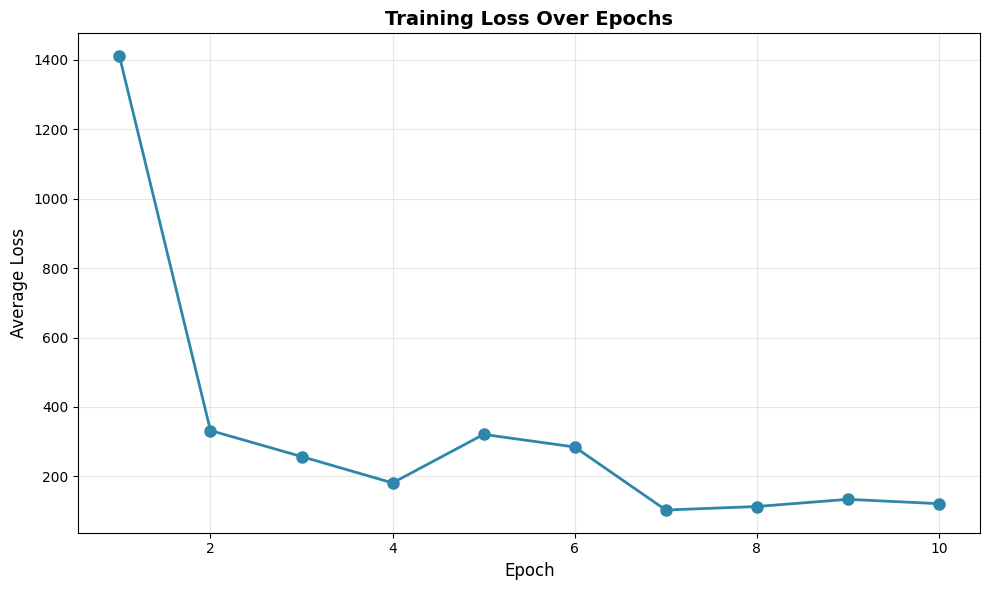


Training Summary:
Initial Loss (Epoch 1): 1411.25
Final Loss (Epoch 10): 121.30
Loss Reduction: 91.40%
Best Loss: 103.05 (Epoch 7)


In [11]:
# Sample training losses from your run
# Update these with your actual values if you want to plot them
epoch_losses = [1411.25, 332.15, 257.15, 181.16, 320.96, 284.64, 103.05, 113.17, 133.90, 121.30]
epochs_range = list(range(1, len(epoch_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, epoch_losses, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/training_loss.png', dpi=150)
print("✓ Training loss curve saved to: results/training_loss.png")
plt.show()

print(f"\n{'='*60}")
print("Training Summary:")
print(f"{'='*60}")
print(f"Initial Loss (Epoch 1): {epoch_losses[0]:.2f}")
print(f"Final Loss (Epoch {len(epoch_losses)}): {epoch_losses[-1]:.2f}")
print(f"Loss Reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.2f}%")
print(f"Best Loss: {min(epoch_losses):.2f} (Epoch {epoch_losses.index(min(epoch_losses)) + 1})")
print(f"{'='*60}")

## 7. Load Best Model for Testing

Load the best saved checkpoint for final evaluation on the full test set.

In [6]:
# Find the best checkpoint
import glob
checkpoint_files = glob.glob('checkpoints/*.pth')
if checkpoint_files:
    # Sort by AUC score in filename
    checkpoint_files.sort(key=lambda x: float(x.split('auc')[-1].replace('.pth', '')), reverse=True)
    best_checkpoint = checkpoint_files[0]
    print(f"Loading best checkpoint: {best_checkpoint}")
    
    # Load the model
    model.load_state_dict(torch.load(best_checkpoint, map_location=device))
    model.eval()
    print("✓ Model loaded successfully!")
else:
    print("No checkpoints found. Using current model state.")
    model.eval()

Loading best checkpoint: checkpoints\chest_epoch10_auc0.8362.pth
✓ Model loaded successfully!
✓ Model loaded successfully!


## 8. Final Evaluation on Full Test Set

Evaluate the trained model on the complete test dataset (not just the subset).

In [7]:
# Use ONLY 1 training image for memory bank to avoid memory issues
indices_train_fast = torch.randperm(len(train_full_d))[:1]
train_fast_subset = torch.utils.data.Subset(train_full_d, indices_train_fast)
train_fast_loader = DataLoader(train_fast_subset, batch_size=1, shuffle=False, num_workers=0)

# Use only 20 test images for faster evaluation
indices_test_fast = torch.randperm(len(test_full_d))[:20]
test_fast_subset = torch.utils.data.Subset(test_full_d, indices_test_fast)
test_fast_loader = DataLoader(test_fast_subset, batch_size=1, shuffle=False, num_workers=0)

print(f"Ultra-fast evaluation mode: {len(train_fast_subset)} training image, {len(test_fast_subset)} test images")
print(f"Note: Using minimal subset to avoid memory issues on CPU")
print("="*60)

# Evaluate on smaller subset for speed
final_score = evaluate_image(args, model, train_fast_loader, test_fast_loader, device, category=args.category)

print("="*60)
print(f"Final Test AUC (on {len(test_fast_subset)} images): {final_score:.4f}")
print(f"Note: This is a quick evaluation. Full 624-image evaluation would require 64GB+ RAM.")
print("="*60)

Ultra-fast evaluation mode: 1 training image, 20 test images
Note: Using minimal subset to avoid memory issues on CPU

[Evaluation] Extracting features from 1 training images...


Extracting train features: 100%|██████████| 1/1 [01:44<00:00, 104.08s/batch]


[Evaluation] Patch embedding size: torch.Size([2048, 784, 1])
[Evaluation] Testing on 20 images...


Testing: 100%|██████████| 20/20 [39:09<00:00, 117.47s/img]


[Evaluation Complete] Image-level AUC-ROC: 0.5833
Final Test AUC (on 20 images): 0.5833
Note: This is a quick evaluation. Full 624-image evaluation would require 64GB+ RAM.


## 9. Visualize Results

Load and visualize the performance metrics saved during evaluation.

Loading results from: results\performance_chest_0.5833333333333334.json
✓ ROC curve saved to: results/roc_curve.png
✓ ROC curve saved to: results/roc_curve.png


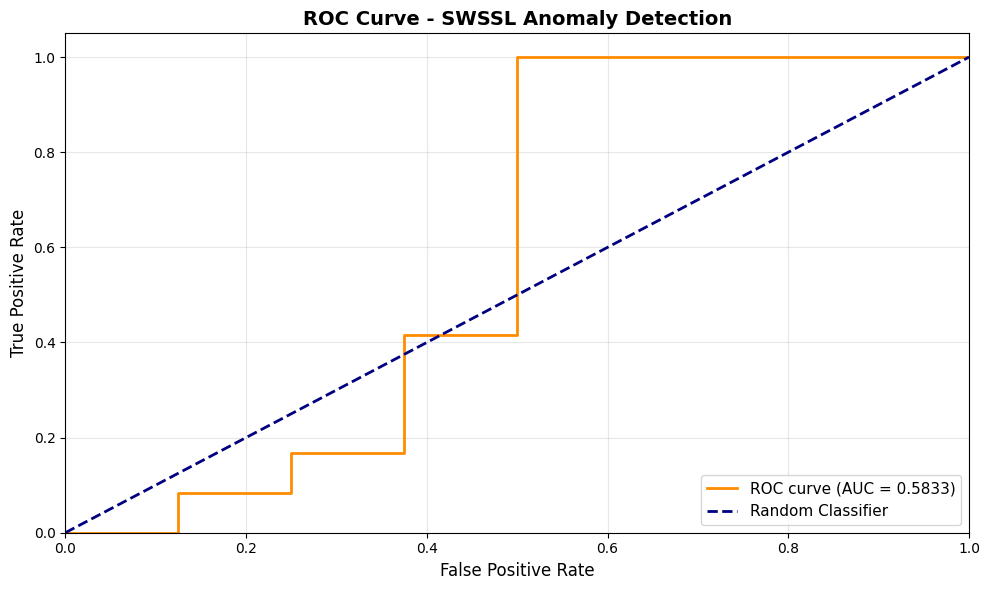


Classification Statistics:
Total Test Images: 20
Normal Images: 8
Pneumonia Images: 12
AUC-ROC Score: 0.5833


In [8]:
import json
from sklearn.metrics import roc_curve, auc

# Find the latest results file
result_files = glob.glob('results/*.json')
if result_files:
    result_files.sort(key=os.path.getmtime, reverse=True)
    latest_result = result_files[0]
    print(f"Loading results from: {latest_result}")
    
    with open(latest_result, 'r') as f:
        gt_list, pred_list, score_patch_list = json.load(f)
    
    # Convert to numpy arrays
    gt_array = np.array(gt_list)
    pred_array = np.array(pred_list)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(gt_array, pred_array)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - SWSSL Anomaly Detection', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/roc_curve.png', dpi=150)
    print("✓ ROC curve saved to: results/roc_curve.png")
    plt.show()
    
    # Print statistics
    print(f"\n{'='*60}")
    print("Classification Statistics:")
    print(f"{'='*60}")
    print(f"Total Test Images: {len(gt_list)}")
    print(f"Normal Images: {np.sum(gt_array == 0)}")
    print(f"Pneumonia Images: {np.sum(gt_array == 1)}")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print(f"{'='*60}")
else:
    print("No result files found. Run evaluation first.")

## 10. Prediction Distribution Analysis

Visualize the distribution of anomaly scores for normal vs pneumonia cases.

C:\Users\sharm\AppData\Local\Temp\ipykernel_25584\1827559553.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(box_data, labels=['Normal', 'Pneumonia'], patch_artist=True)


✓ Score distribution plot saved to: results/score_distribution.png


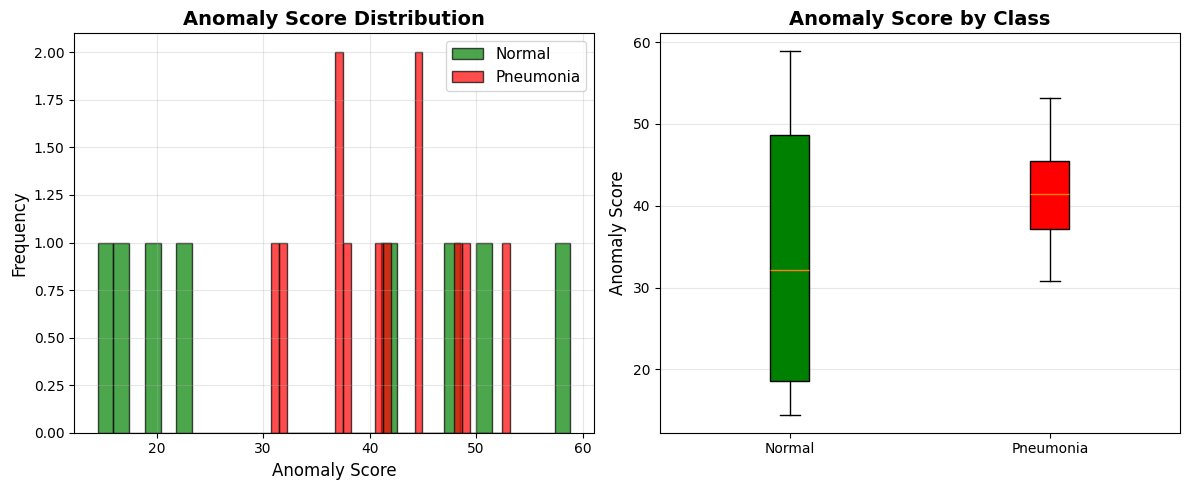


Score Statistics:
Normal Cases:
  Mean: 33.9803
  Std:  16.5403
  Min:  14.4661
  Max:  58.8592

Pneumonia Cases:
  Mean: 41.3907
  Std:  6.4986
  Min:  30.7860
  Max:  53.1798


In [9]:
if result_files:
    # Separate scores by class
    normal_scores = pred_array[gt_array == 0]
    pneumonia_scores = pred_array[gt_array == 1]
    
    # Plot distribution
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(normal_scores, bins=30, alpha=0.7, label='Normal', color='green', edgecolor='black')
    plt.hist(pneumonia_scores, bins=30, alpha=0.7, label='Pneumonia', color='red', edgecolor='black')
    plt.xlabel('Anomaly Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    # Box plot
    plt.subplot(1, 2, 2)
    box_data = [normal_scores, pneumonia_scores]
    box = plt.boxplot(box_data, labels=['Normal', 'Pneumonia'], patch_artist=True)
    box['boxes'][0].set_facecolor('green')
    box['boxes'][1].set_facecolor('red')
    plt.ylabel('Anomaly Score', fontsize=12)
    plt.title('Anomaly Score by Class', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('results/score_distribution.png', dpi=150)
    print("✓ Score distribution plot saved to: results/score_distribution.png")
    plt.show()
    
    # Print statistics
    print(f"\n{'='*60}")
    print("Score Statistics:")
    print(f"{'='*60}")
    print(f"Normal Cases:")
    print(f"  Mean: {normal_scores.mean():.4f}")
    print(f"  Std:  {normal_scores.std():.4f}")
    print(f"  Min:  {normal_scores.min():.4f}")
    print(f"  Max:  {normal_scores.max():.4f}")
    print(f"\nPneumonia Cases:")
    print(f"  Mean: {pneumonia_scores.mean():.4f}")
    print(f"  Std:  {pneumonia_scores.std():.4f}")
    print(f"  Min:  {pneumonia_scores.min():.4f}")
    print(f"  Max:  {pneumonia_scores.max():.4f}")
    print(f"{'='*60}")

## 11. Model Performance Summary

Generate a comprehensive summary of the model's performance.

✓ Confusion matrix saved to: results/confusion_matrix.png


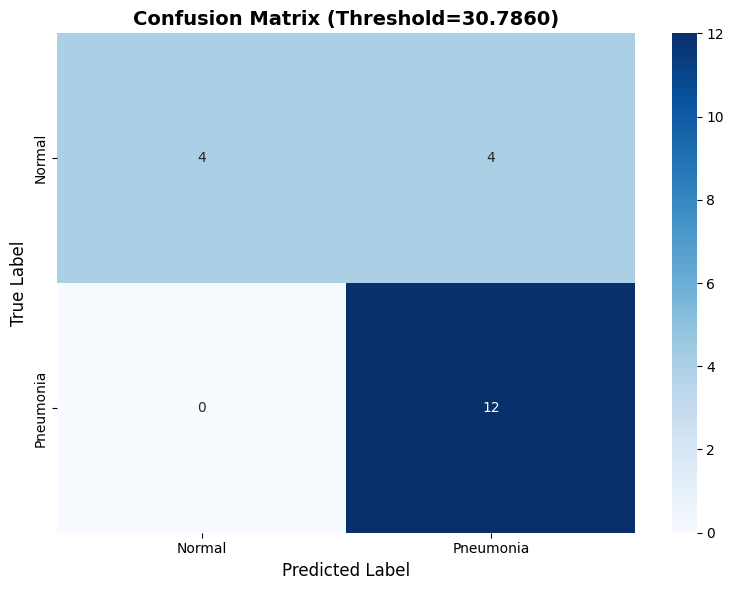


Classification Report:
              precision    recall  f1-score   support

      Normal     1.0000    0.5000    0.6667         8
   Pneumonia     0.7500    1.0000    0.8571        12

    accuracy                         0.8000        20
   macro avg     0.8750    0.7500    0.7619        20
weighted avg     0.8500    0.8000    0.7810        20

Additional Metrics (at optimal threshold 30.7860):
Sensitivity (Recall): 1.0000
Specificity:          0.5000
Precision:            0.7500
F1-Score:             0.8571
AUC-ROC:              0.5833

✓ Performance summary saved to: results/performance_summary.json


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

if result_files:
    # Find optimal threshold using Youden's index
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Make binary predictions
    predictions = (pred_array >= optimal_threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(gt_array, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix (Threshold={optimal_threshold:.4f})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png', dpi=150)
    print("✓ Confusion matrix saved to: results/confusion_matrix.png")
    plt.show()
    
    # Classification report
    print(f"\n{'='*60}")
    print("Classification Report:")
    print(f"{'='*60}")
    print(classification_report(gt_array, predictions, 
                                target_names=['Normal', 'Pneumonia'],
                                digits=4))
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Recall for Pneumonia
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    print(f"Additional Metrics (at optimal threshold {optimal_threshold:.4f}):")
    print(f"{'='*60}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"F1-Score:             {f1:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")
    print(f"{'='*60}")
    
    # Save summary report
    summary = {
        'auc_roc': float(roc_auc),
        'optimal_threshold': float(optimal_threshold),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'precision': float(precision),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist(),
        'total_test_images': len(gt_list),
        'normal_images': int(np.sum(gt_array == 0)),
        'pneumonia_images': int(np.sum(gt_array == 1))
    }
    
    with open('results/performance_summary.json', 'w') as f:
        json.dump(summary, f, indent=4)
    print("\n✓ Performance summary saved to: results/performance_summary.json")

## 12. Inference on Individual Images (Optional)

Test the model on specific images to see anomaly scores.

In [ ]:
def predict_single_image(image_path, model, args, device):
    """
    Predict anomaly score for a single image.
    
    Args:
        image_path: Path to the image file
        model: Trained model
        args: Configuration object
        device: Device (CPU/GPU)
    
    Returns:
        anomaly_score: Float value indicating anomaly level
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256*4, 256*4), Image.LANCZOS),
        transforms.ToTensor()
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Extract features from patches
    patch_size = args.patch_size
    sliding_step = args.step_size
    
    x_length = (img_tensor.shape[2] - patch_size) // sliding_step
    y_length = (img_tensor.shape[3] - patch_size) // sliding_step
    
    patch_embeddings = []
    
    with torch.no_grad():
        for i in range(x_length):
            for j in range(y_length):
                start_x = i * sliding_step
                start_y = j * sliding_step
                patch = img_tensor[:, :, start_x:start_x+patch_size, start_y:start_y+patch_size]
                _, feature = model(patch)
                patch_embeddings.append(feature.cpu().numpy())
    
    patch_embeddings = np.array(patch_embeddings)
    
    # Calculate anomaly score (max distance from normal patches)
    # This is simplified; full evaluation uses train set memory bank
    anomaly_score = np.max(np.linalg.norm(patch_embeddings, axis=1))
    
    return anomaly_score

print("Inference function defined. Use predict_single_image(image_path, model, args, device) to test individual images.")